# Bio Embeddings for Shallow Learners
1) Choose a VOG
2) Choose and create bio embedding algorithm: SeqVec, ProtTrans 
    - Input: VOG specific .fasta file
    - Store sequences as objects in a list
    - Create embedder object and then a protein- or aminoacid-embedding
    - Output: Vector of sequences represented/embedded as points in a multidimensional (feature-) space (vector of vectors). The embeddings harbor a constant number of features, in contrast to the previous state, where protein sequences had different lengths. So the VOG has now this embedding matrix as a profile.

**Links:**
- [SeqVec Repository](https://github.com/Rostlab/SeqVec)
    - [SeqVec Source-Code](https://github.com/Rostlab/SeqVec/blob/master/seqvec/seqvec.py)
- [ProtTrans Respository](https://github.com/agemagician/ProtTrans)
- [Embedder Benchmark Paper](https://www.mdpi.com/1422-0067/24/4/3775)
    

## o) Install and Load Libraries

In [1]:
# !pip install seqvec

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
from Bio import SeqIO
from bio_embeddings.embed import ProtTransBertBFDEmbedder
from bio_embeddings.embed.seqvec_embedder import SeqVecEmbedder
from bio_embeddings.project import tsne_reduce
from bio_embeddings.visualize import render_3D_scatter_plotly


/home/dinglemittens/anaconda3/envs/SPEnv38/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## o) Generate Embedding: SeqVec
### Input: .fasta file | Output: array of embedding vectors

In [3]:
# filepath = "BE_testing/tiny_sampled.fasta"
# # !seqvec -i $filepath -o embeddings.npz
# !seqvec -i $filepath -o embeddings.npz --split-char ' ' --id 0


## o) Generate Bio-Embeddings (in progress)
see <embed_fasta_sequences.ipynb>

In [4]:
# # Create (download) testing fasta file (tiny_sampled.fasta)
# !wget http://data.bioembeddings.com/public/embeddings/notebooks/custom_data/tiny_sampled.fasta --output-document BE_testing/tiny_sampled.fasta

In [30]:
# Extract sequences from fasta file and store them as a list
filepath = "BE_testing/tiny_sampled.fasta"
# filepath = "BE_testing/VOG1_trial2/VOG00001.faa"
sequences = []
for record in SeqIO.parse(filepath, "fasta"):
    sequences.append(record)

# Sanity-check (First 3 and last 3 sequences)
print(f"Member-ID     Identifier\t\tLength\t    Sequence\n")
for i,s in enumerate(sequences[:3]): # s:SeqIO-object
    print(f"Protein {i+1:<6}{(s.id):<28}{len(s.seq):<10}{s.seq}") # :<6 for proper output alignment
print(". . .")
for i,s in enumerate(sequences[-3:], start=len(sequences)-2):
    print(f"Protein {i+1:<6}{(s.id):<28}{len(s.seq):<10}{s.seq}")


Member-ID     Identifier		Length	    Sequence

Protein 1     1094892.YP_004894869.1      485       MFFTINNNSLKSSNNDGTNNTYIKIFNIQDIEQMYNLGTTLYIIKTNGQHNVNAYNKTMCTNQFEIISKYSLYDISTYEYFGLDITKNIYIVDFACKEGNIDFLNWWLSSGYDLKYTQIGMDNANRFKEIEILNWWVNSGLEMRYTYKSMDRASNLALFDILNWWITSGLPLKYSESSMNLDYFASLSEEDEIRVLTWWKESGLLLKYNHSAIDNASRKMHINVLNWWIESGLDICYSENSIDCITISNNTKILDWWLESGLKIKYTELAIDIASRYFSFDVLDWWLKSGLEFKYTSDSLDDINLDYFTNINQEEDEYEVIKLLNWWKSSGLELRYTNLCLDAMSEYGYIKVLDWFKNSELPILYSIEAIDCTDDINVLEWWIKSDLPLKYSCKAMNICTNIEILQWWISSGLTIKYNEHLIDGAFTNDRIDILEFMLSSGLPFIHSKYCVLGYMEKIPELSVKWWIKRELPKEYISNINSIDKN
Protein 2     1247379.YP_010779223.1      460       MLVYITNGRHKSIDVDGVYDSSNFLTAFNINEIKKYYCLGHQLHIINMKNNSSDIESEKKGDNKYIADDIPIEKIYNKFKIIESYSLYDINTYIKLGIDIRENNHIVDIASKEGNIDFLNWWISNDLDLKYSEKSLDDASDYGHIDVLNWWFHSNLPLRYSKNSTNFKLNIKLEVKDKIKVLDWWYNSGLDIIYDEGSMDNASNNCEREILDWWVNSGLKLKYSERSMDDASMFNKIDVLNWWFMSGLELKYSDIAIDYASKNQFINVLDWWKNSNLPLKYSNLSIDEVNEYYYLEDDKSYLNVLEWWKNSGLELKYSERCIDSFSRCGEIAGLEWWKNSGLELRYSECSIVDIVDPNILQWW

In [15]:
# Generate Embedder Object
embedder = ProtTransBertBFDEmbedder()
# embedder = SeqVecEmbedder()

In [16]:
# Compute Amino Acid Level Embedding (takes quiet some time)
aa_embeddings = embedder.embed_many([str(s.seq) for s in sequences])
# `embed_many` returns a generator.
# We want to keep both RAW embeddings and reduced embeddings in memory.
# To do so, we simply turn the generator into a list!
# (this will start embedding the sequences!)
# Needs certain amount of GPU RAM, if not sufficient CPU is used (slower)
aa_embeddings = list(aa_embeddings)

sm_86 pytorch compatibility issue:
- wrong pytorch version prevented using the GPU for the following embedding computation.
- solved: conda install pytorch==1.10.0 torchvision==0.11.0 torchaudio==0.10.0 cudatoolkit=11.3 -c pytorch -c conda-forge

About SeqVec:
- https://github.com/Rostlab/SeqVec/blob/master/README.md : "All results built upon the embeddings gained from the new tool SeqVec neither explicitly nor implicitly using evolutionary information. Nevertheless, it improved over some methods using such information. Where the lightning-fast HHblits needed on average about two minutes to generate the evolutionary information for a target protein, SeqVec created the vector representation on average in 0.03 seconds."
- Directory: - \\wsl.localhost\Ubuntu\home\dinglemittens\anaconda3\envs\SPEnv38\lib\python3.8\site-packages\bio_embeddings\embed


Trouble with Speed:
- Managed to install the proper pytorch version such that the embedder does not have to use the CPU, but it still took (too?) long. Interrupted after 77min for SeqVecEmbedder(). Interruption after 40 min for ProtTransBertBFDEmbedder().
- For the tiny_sampled.fasta file which harbors 12 sequences of a total length of 3682 aminoacids, the embedding run took 43 seconds, which are ~5k aminoacids per minute.

In [17]:
# Print Shape of Amino Acid Level Embedding
print("amino acid level embeddings object shape:")
print("o) 3 dimensional list of a number of <len(sequences)> embedding matrices with 1024 rows and <len(seq)> columns") #
print(f"o) 1st D (number of sequences)\t{len(aa_embeddings)}")
print(f"o) 2nd D (sequence length)\t{len(aa_embeddings[0])} (depending on sequence)")
print(f"o) 3rd D (embedding dimensions)\t{len(aa_embeddings[0][0])} (constant)")

amino acid level embeddings object shape:
o) 3 dimensional list of a number of <len(sequences)> embedding matrices with 1024 rows and <len(seq)> columns
o) 1st D (number of sequences)	12
o) 2nd D (sequence length)	129 (depending on sequence)
o) 3rd D (embedding dimensions)	1024 (constant)


In [18]:
# Compute Protein Level Embedding
protein_embeddings = [embedder.reduce_per_protein(e) for e in aa_embeddings]
# mean of amino acid level vectors

In [19]:
# Print Shape of Protein Level Embedding
print("protein level embeddings-object shape:")
print("o) 2 dimensional list of <len(sequences)> embedding vectors with 1024 entries")
print(f"o) 1st D (number of sequences)\t{len(protein_embeddings)}")
print(f"o) 2nd D (embedding dimensions)\t{len(protein_embeddings[0])} (constant)")

protein level embeddings-object shape:
o) 2 dimensional list of <len(sequences)> embedding vectors with 1024 entries
o) 1st D (number of sequences)	12
o) 2nd D (embedding dimensions)	1024 (constant)


In [22]:
# Print Summary of Embedding Shapes:  Sequence | AA Level Embedding | Protein Level Embedding
print("Member ID\tAA Level Embedding\tProtein Level Embedding")
for i, (per_amino_acid, per_protein) in enumerate(zip(aa_embeddings, protein_embeddings)):
    print(f"Protein {i+1}\t{per_amino_acid.shape}\t\t{per_protein.shape}")
print("\nAA embedding should have shape (seq-length, embedding-dimensions), Protein embedding (embedding-dimensions,)")

Member ID	AA Level Embedding	Protein Level Embedding
Protein 1	(129, 1024)		(1024,)
Protein 2	(129, 1024)		(1024,)
Protein 3	(46, 1024)		(1024,)
Protein 4	(133, 1024)		(1024,)
Protein 5	(172, 1024)		(1024,)
Protein 6	(386, 1024)		(1024,)
Protein 7	(133, 1024)		(1024,)
Protein 8	(207, 1024)		(1024,)
Protein 9	(165, 1024)		(1024,)
Protein 10	(439, 1024)		(1024,)
Protein 11	(159, 1024)		(1024,)
Protein 12	(1584, 1024)		(1024,)

AA embedding should have shape (seq-length, embedding-dimensions), Protein embedding (embedding-dimensions,)


## o) Projecting high dimensional embedding space to a 3D space
see <project_visualize_pipeline_embeddings.ipynb> (Bio-embeddings GitHub)

In [26]:
# Configure tsne options
options = {
    'perplexity': 3, # Low perplexity values (e.g., 3) cause t-SNE to focus more on preserving the local structure of the data (high, e.g. 30).
    'n_iter': 500 # number of iterations for the tsne algorithm
}

# Apply TSNE Projection 
projected_p_embedding = tsne_reduce(protein_embeddings, **options) # list

# Display Projected Embedding (from 1024 dimensional (Protein Level) vectors to 3 dimensional coordinate vectors)
print(f"\nShape of projected/dimensionality-reduced protein level embedding: {projected_p_embedding.shape}\n")
for i,embedding in enumerate(projected_p_embedding[:3]): # first 3
    print(f"Protein {i+1}\t{embedding}")
print(". . .")
for i,embedding in enumerate(projected_p_embedding[-3:]): # last 3
    print(f"Protein {i+len(projected_p_embedding)-2}\t{embedding}")
print() 

[t-SNE] Computing 10 nearest neighbors...
[t-SNE] Indexed 12 samples in 0.000s...
[t-SNE] Computed neighbors for 12 samples in 0.042s...
[t-SNE] Computed conditional probabilities for sample 12 / 12
[t-SNE] Mean sigma: 0.299232
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.311325
[t-SNE] KL divergence after 500 iterations: 1.467052

Shape of projected/dimensionality-reduced protein level embedding: (12, 3)

Protein 1	[33.921696 99.73534  90.20397 ]
Protein 2	[-14.111142 128.08607    3.743935]
Protein 3	[-82.94825  37.3402  128.35439]
. . .
Protein 10	[171.6438   -41.594696  24.424093]
Protein 11	[-149.8983   -135.20859    14.519402]
Protein 12	[ 53.71601  -51.25498   38.405457]



/home/dinglemittens/anaconda3/envs/SPEnv38/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


## o) Visualization of the Data
see <project_visualize_pipeline_embeddings.ipynb> (Bio-embeddings GitHub)

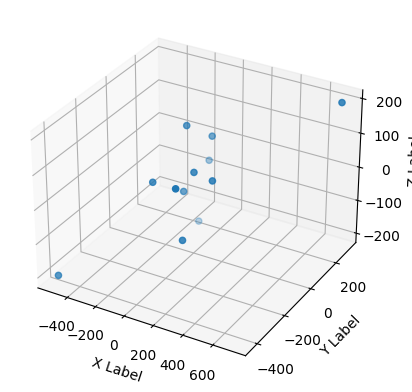

In [27]:
# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Extract x, y, and z coordinates from the data
x = projected_p_embedding[:, 0]
y = projected_p_embedding[:, 1]
z = projected_p_embedding[:, 2]

# Plot the points
ax.scatter(x, y, z)

# Set labels for each axis
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

# Show the plot
plt.show()


In [ ]:
# Via plotly.express
import plotly.express as px

fig = px.scatter_3d(
    projected_p_embedding, x=0, y=1, z=2,
    labels={'0': 'label 1', '1': 'label 2', '2': 'label 3'}
)
fig.show()

In [ ]:
# raw code from ChatGTP
import plotly.express as px
from sklearn.decomposition import PCA

df = px.data.iris()
X = df[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']]

pca = PCA(n_components=3)
components = pca.fit_transform(X)

total_var = pca.explained_variance_ratio_.sum() * 100

fig = px.scatter_3d(
    components, x=0, y=1, z=2, color=df['species'],
    title=f'Total Explained Variance: {total_var:.2f}%',
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'}
)
fig.show()